# Project Overview

# Credit Risk / Loan Default Prediction

## Objective
The objective of this project is to predict the probability of loan default
using applicant demographic, financial, and credit history data.

The model is designed to assist financial institutions in:
- Identifying high-risk applicants
- Reducing loan default losses
- Supporting data-driven loan approval decisions

This project follows an end-to-end, production-aware machine learning workflow.


## Business Problem

Loan default is a critical risk for banks and fintech companies.
Approving loans for high-risk applicants can lead to financial losses,
while rejecting low-risk applicants can reduce business growth.

The key challenge is to:
- Minimize false approvals of risky customers
- Balance risk and revenue
- Maintain transparency and fairness in decision-making

## Dataset Overview

This project uses the **Home Credit Default Risk** dataset from Kaggle.

Each row represents a loan applicant and contains:
- Personal demographics
- Income and employment details
- Credit history
- Loan-related attributes

### Target Variable
- TARGET = 1 → Applicant defaulted on the loan
- TARGET = 0 → Applicant repaid the loan


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

plt.style.use("default")


## Load Dataset

The training dataset contains the target variable.
The test dataset does not contain the target and will be used later
for prediction and inference.


In [2]:
train_df = pd.read_csv("../data/raw/application_train.csv")
test_df  = pd.read_csv("../data/raw/application_test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (307511, 122)
Test shape: (48744, 121)


## Initial Data Inspection

We inspect the dataset to understand:
- Number of features
- Data types
- Potential quality issues


In [3]:
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


## Target Variable Distribution

Understanding class distribution is critical in credit risk modeling.
Loan default datasets are typically imbalanced, which impacts
model training and evaluation.

In [6]:
train_df["TARGET"].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [7]:
train_df["TARGET"].value_counts(normalize=True)


TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

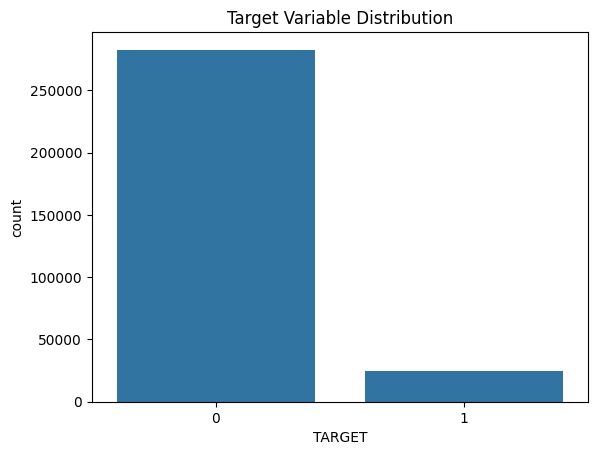

In [9]:
sns.countplot(x="TARGET", data=train_df)
plt.title("Target Variable Distribution")
plt.show()

### Observation

The dataset is highly imbalanced, with significantly fewer default cases
compared to non-default cases.

This imbalance must be addressed during model training to avoid biased predictions.


## Missing Value Analysis

Real-world financial datasets often contain missing values due to
incomplete records or data collection limitations.

We analyze missing values to determine appropriate cleaning strategies.


In [11]:
missing_percent = train_df.isnull().mean().sort_values(ascending=False)
missing_percent.head(15)


COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
COMMONAREA_MEDI             0.698723
NONLIVINGAPARTMENTS_MEDI    0.694330
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MEDI       0.683550
LIVINGAPARTMENTS_MODE       0.683550
FLOORSMIN_MODE              0.678486
FLOORSMIN_AVG               0.678486
FLOORSMIN_MEDI              0.678486
YEARS_BUILD_AVG             0.664978
YEARS_BUILD_MODE            0.664978
dtype: float64

## Handling High Missing Value Columns

Columns with more than 40% missing values are removed because:
- They provide limited reliable information
- Imputation may introduce noise
- They increase model complexity unnecessarily

In [12]:
drop_cols = missing_percent[missing_percent > 0.4].index

train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

print("Remaining features:", train_df.shape[1])

Remaining features: 73


## Separating Numerical and Categorical Features

Numerical and categorical features require different preprocessing techniques.
We separate them to apply appropriate handling methods.


In [13]:
num_cols = train_df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = train_df.select_dtypes(include=["object"]).columns

num_cols = num_cols.drop("TARGET")


## Handling Missing Values

### Numerical Features
Missing numerical values are replaced with the median, which is robust to outliers.

### Categorical Features
Missing categorical values are replaced with "Unknown" to preserve missingness
as potential information.


In [14]:
train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())
test_df[num_cols]  = test_df[num_cols].fillna(train_df[num_cols].median())

train_df[cat_cols] = train_df[cat_cols].fillna("Unknown")
test_df[cat_cols]  = test_df[cat_cols].fillna("Unknown")


## Data Validation

We verify that all missing values have been handled successfully.


In [15]:
train_df.isnull().sum().sum()


np.int64(0)

## Save Cleaned Dataset

The cleaned dataset is saved for reproducibility and further
feature engineering and modeling.


In [16]:
train_df.to_csv("../data/processed/train_cleaned.csv", index=False)
test_df.to_csv("../data/processed/test_cleaned.csv", index=False)

## Summary of Step 1

In this notebook, we:
- Defined the business problem and objective
- Inspected the dataset structure
- Analyzed target imbalance
- Removed low-quality features
- Handled missing values
- Saved cleaned datasets for downstream processing

The data is now ready for feature engineering.
